In [1]:
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from matplotlib.image import imread

In [2]:
# Standard function we used in more programs to create a nice table using pandas df
def get_table(sims):
    """
    This function takes the output produced by either the compute_similarities 
    or compute_similarities_testsets function, and returns a pandas dataframe/table 
    and also saves it in excel.
    """
    
    data = {}
    rows = []

    for (key1, key2), value in sims.items():
        file1 = os.path.basename(key1).split('.')[0]
        file2 = os.path.basename(key2).split('.')[0]
        
        if file1 not in data:
            data[file1] = []
        if file2 not in rows:
            rows.append(file2)
        
        value = np.round(value, 3)
        data[file1].append(value)
        
    data = {key: value for key, value in sorted(data.items())}
    rows = sorted(rows)
    rows_indices_begin = list(range(len(rows)))
    data_values = list(data.values())
    rows_indices_end = sorted(rows_indices_begin, key=lambda i: rows[i])
    
    for key, value in data.items():
        new_value = []
        for i in rows_indices_end:
            new_value.append(value[i])
        data[key] = new_value
    
    df = pd.DataFrame(data, index=rows)
    return df.T

In [3]:
def orb_similarity(img1, img2):
    #Best parameters: (200, 1.1, 8, 3, 0, 41, 30)
    orb = cv2.ORB_create(nfeatures=200,scaleFactor=1.1,nlevels=8,WTA_K=3, 
                          scoreType=cv2.ORB_HARRIS_SCORE, patchSize=41, fastThreshold=30)
    kp1, des1 = orb.detectAndCompute(img1, None)
    kp2, des2 = orb.detectAndCompute(img2, None)
    if des1 is None or des2 is None:
        return 0.0

    # Use BFMatcher with default params
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    # Match descriptors
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)

    # Apply RANSAC to find the best transformation
    src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
    if len(matches) < 10:
         return 0.0
    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 15)
    matches_mask = mask.ravel().tolist()

    num_inliers = np.sum(matches_mask)
    num_matches = len(matches)
    
    similarity_percentage = (num_inliers / num_matches) * 100
    return similarity_percentage


In [4]:
def compute_similarities_testsets(munich_testset, nk_testset, 
                                  munich_path="munich_testset", 
                                  nk_path="nk_testset"):
    """
    Computes similarities between images from Munich and NK test sets using ORB features.
    """
    # Create an empty dictionary
    similarities = {}

    # Loop through all NK images
    for nk_img in nk_testset:
        nk_img_path = os.path.join(nk_path, nk_img)
        try:
            nk_img = cv2.imread(nk_img_path, cv2.IMREAD_GRAYSCALE)
            if nk_img is None:
                raise ValueError(f"Image at {nk_img_path} could not be loaded.")
        except ValueError as e:
            print(e)
            continue

        # Loop through all munich images
        for munich_img in munich_testset:
            munich_img_path = os.path.join(munich_path, munich_img)
            try:
                munich_img = cv2.imread(munich_img_path, cv2.IMREAD_GRAYSCALE)
                if munich_img is None:
                    raise ValueError(f"Image at {munich_img_path} could not be loaded.")
            except ValueError as e:
                print(e)
                continue
            # Create all matches and save them in the dictionary
            similarity = orb_similarity(nk_img, munich_img)
            similarities[(nk_img_path, munich_img_path)] = similarity
        
    return similarities

nk_path = "nk_testset"
munich_path = "munich_testset"
nk_path_no_back = "nk_testset_no_back"
munich_path_no_back = "munich_testset_no_back"

if not os.path.exists(nk_path):
    raise FileNotFoundError(f"The path {nk_path} does not exist.")
if not os.path.exists(munich_path):
    raise FileNotFoundError(f"The path {munich_path} does not exist.")

nk_testset = os.listdir(nk_path)
munich_testset = os.listdir(munich_path)
nk_testset_no_back = os.listdir(nk_path_no_back)
munich_testset_no_back = os.listdir(munich_path_no_back)

# Find all the 25 matches from the testset and create the table.
print("25 testset matches with regular background")
sims = compute_similarities_testsets(munich_testset, nk_testset, munich_path, nk_path)
get_table(sims)

25 testset matches with regular background


,card_table_mccp,chair_mccp,cupboard_mccp,dresser_mccp,dressoir_mccp,kast_mccp,speeltafel_mccp,stoel_mccp,table_mccp,tafel_mccp
card_table_nk,37.037,35.714,34.783,31.250,31.250,34.783,37.037,35.714,36.364,36.364
chair_nk,26.667,50.000,33.333,33.333,33.333,33.333,26.667,50.000,35.294,35.294
cupboard_nk,33.333,43.750,33.333,42.857,42.857,33.333,33.333,43.750,36.000,36.000
dresser_nk,35.484,41.935,37.931,57.143,57.143,37.931,35.484,41.935,31.579,31.579
dressoir_nk,35.484,41.935,37.931,57.143,57.143,37.931,35.484,41.935,31.579,31.579
kast_nk,33.333,43.750,33.333,42.857,42.857,33.333,33.333,43.750,36.000,36.000
speeltafel_nk,37.037,35.714,34.783,31.250,31.250,34.783,37.037,35.714,36.364,36.364
stoel_nk,26.667,50.000,33.333,33.333,33.333,33.333,26.667,50.000,35.294,35.294
table_nk,23.077,34.783,31.034,42.857,42.857,31.034,23.077,34.783,26.923,26.923
tafel_nk,23.077,34.783,31.034,42.857,42.857,31.034,23.077,34.783,26.923,26.923


In [5]:
# Find all the 25 matches from the testset with no background and create the table.
print("25 testset matches with background removal")
sims = compute_similarities_testsets(munich_testset_no_back, nk_testset_no_back, munich_path_no_back, nk_path_no_back)
get_table(sims)

25 testset matches with background removal


,card_table_mccp,chair_mccp,cupboard_mccp,dresser_mccp,dressoir_mccp,kast_mccp,speeltafel_mccp,stoel_mccp,table_mccp,tafel_mccp
card_table_nk,42.857,33.333,35.000,26.667,26.667,35.000,42.857,33.333,34.483,34.483
chair_nk,46.154,66.667,26.923,29.167,29.167,26.923,46.154,66.667,34.783,34.783
cupboard_nk,44.444,45.000,32.143,28.571,28.571,32.143,44.444,45.000,32.000,32.000
dresser_nk,53.846,46.154,33.333,31.429,31.429,33.333,53.846,46.154,37.500,37.500
dressoir_nk,53.846,46.154,33.333,31.429,31.429,33.333,53.846,46.154,37.500,37.500
kast_nk,44.444,45.000,32.143,28.571,28.571,32.143,44.444,45.000,32.000,32.000
speeltafel_nk,42.857,33.333,35.000,26.667,26.667,35.000,42.857,33.333,34.483,34.483
stoel_nk,46.154,66.667,26.923,29.167,29.167,26.923,46.154,66.667,34.783,34.783
table_nk,39.130,37.500,24.138,30.435,30.435,24.138,39.130,37.500,40.909,40.909
tafel_nk,39.130,37.500,24.138,30.435,30.435,24.138,39.130,37.500,40.909,40.909


In [6]:
def compute_similarities(nk_img_path, munich_imgs, path):
    """
    This function takes three arguments: 
    - nk_img, which is a single image from the nk collection. 
    - munich_imgs, this contains all images from the Munich Database. 
    - path, this is the path to the gray scaled Munich Database.
    
    It then computes the feature descriptor for the nk collection image and all the images in the \
    Munich Database. Afterwards takes the dot-product to get the dot-product similiarity. It then \
    saves the similarity and the two images as key-value pairs in a dictionary. 
    """
    
    nk_img = cv2.imread(nk_img_path, cv2.IMREAD_GRAYSCALE)
    similarities = {}
    i = 0

    for img_name in munich_imgs:
        if i == 50:
            break
        if i % 10 == 0:
            print(i)
        i += 1
        img_path = os.path.join(path, img_name)
        munich_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        if nk_img is not None and munich_img is not None:
            similarity = orb_similarity(nk_img, munich_img)
            nk_img_name = os.path.basename(nk_img_path)
            munich_img_name = os.path.basename(img_path)
            similarities[(nk_img_name, munich_img_name)] = similarity

    return similarities

# Example usage
nk_img = "nk_testset/chair_nk.jpg"
munich_imgs = os.listdir("scraped_images_grayscaled_big")
path = "scraped_images_grayscaled_big"

# Only tested on first 50 images which already took 22 seconds. for 47.000 images this would take 5+ hours.
similarities = compute_similarities(nk_img, munich_imgs, path)

0
10
20
30
40


Top 10 similar images for NK image 'chair_nk.jpg':


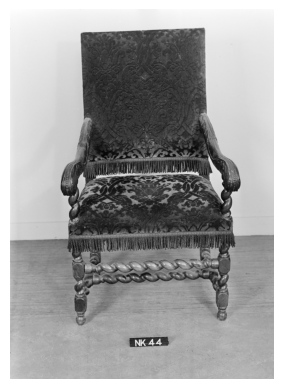

Munich image '0026_15-17_id=cp141990_badv.jpg' (Similarity: 70.0)


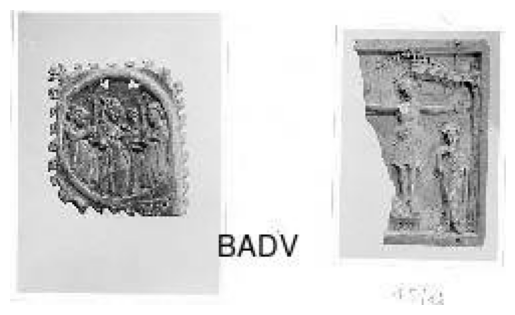

Munich image '0026_15-15_id=cp141988_badv.jpg' (Similarity: 66.66666666666666)


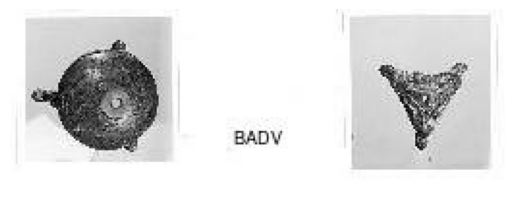

Munich image '0026_15-18_id=cp141991_badv.jpg' (Similarity: 61.53846153846154)


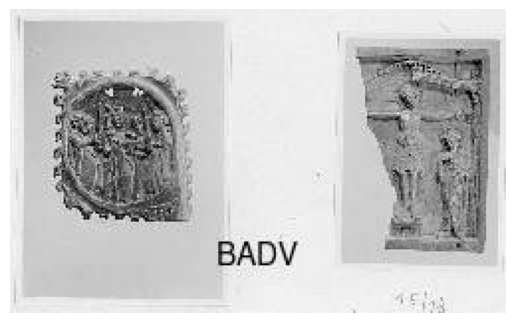

Munich image '0025_15-9_id=cp141994_badv.jpg' (Similarity: 60.0)


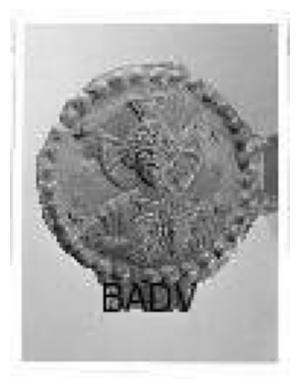

Munich image '0025_8-6_id=cp173967_badv.jpg' (Similarity: 59.09090909090909)


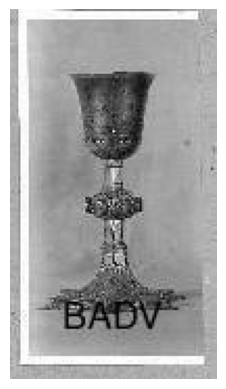

Munich image '0025_14_id=cp140984_badv.jpg' (Similarity: 58.82352941176471)


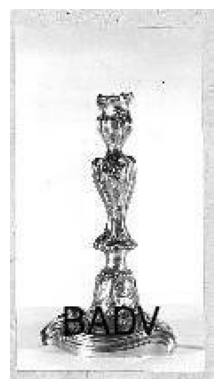

Munich image '0026_15-10_id=cp141987_badv.jpg' (Similarity: 57.14285714285714)


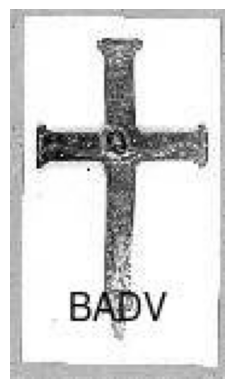

Munich image '00100_531-1_id=cp168313_badv.jpg' (Similarity: 55.55555555555556)


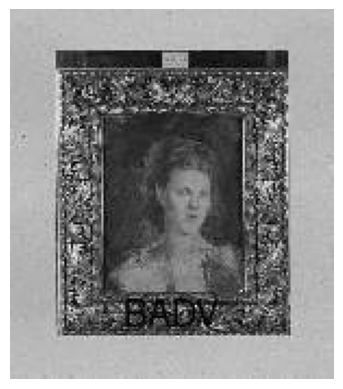

Munich image '00100_549-1_id=cp168622_badv.jpg' (Similarity: 55.55555555555556)


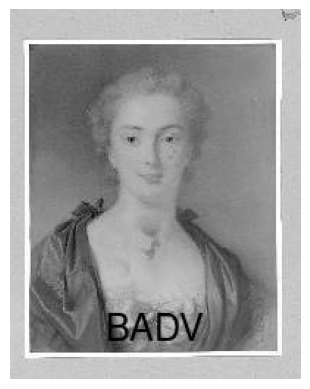

Munich image '0026_15-16_id=cp141989_badv.jpg' (Similarity: 55.00000000000001)


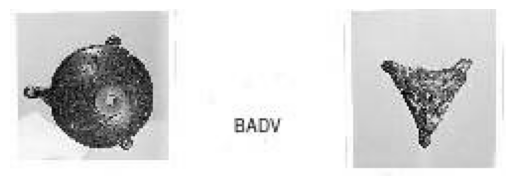

In [7]:
def get_top_10_similarities(similarities):
    """
    Get the top 10 highest similarity values for each NK image from the similarities dictionary.
    
    Parameters:
    - similarities: A dictionary where keys are (NK image name, Munich image name) tuples
                    and values are similarity scores.
                    
    Returns:
    - A dictionary where keys are NK image names and values are lists of tuples
      (Munich image name, similarity) sorted by similarity in descending order.
    """
    top_10_similarities = {}
    
    for nk_img_name in set(key[0] for key in similarities.keys()):
        # Filter similarities for current NK image
        nk_similarities = [(munich_img_name, similarity) for (nk, munich_img_name), similarity in similarities.items() if nk == nk_img_name]
        
        # Sort by similarity in descending order
        sorted_similarities = sorted(nk_similarities, key=lambda x: x[1], reverse=True)
        
        # Get top 10 similarities
        top_10_similarities[nk_img_name] = sorted_similarities[:10]
    
    return top_10_similarities

def display_image(image_path):
    image = imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

def display_nk_image(nk_img_name):
    image_path = f"{nk_path}/{nk_img_name}"
    image = imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

top_10 = get_top_10_similarities(similarities)
for nk_img_name, similar_images in top_10.items():
    print(f"Top 10 similar images for NK image '{nk_img_name}':")
    display_nk_image(nk_img_name)
    for munich_img_name, similarity in similar_images:
        image_path = f"scraped_images_grayscaled_big/{munich_img_name}"
        print(f"Munich image '{munich_img_name}' (Similarity: {similarity})")
        display_image(image_path)
        
# This only looks at the first 50 images from the large dataset.
# We are already getting high similarities of 70% for our highest rank that looks nothing like the chair
# We dropped ORB, not because of lack of speed but because of lack of accurarcy.

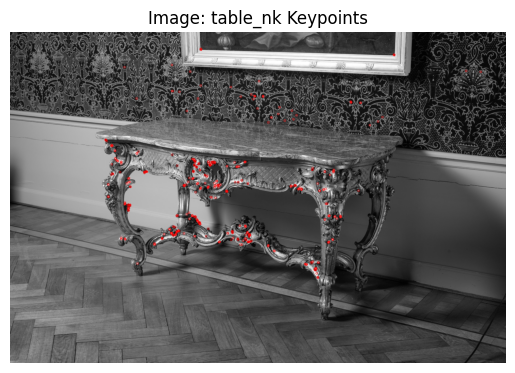

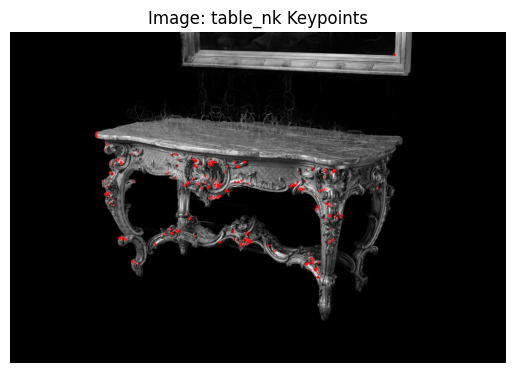

In [8]:
def visualize_keypoints(image_path):
    # Load the image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError("The image path is invalid.")

    orb = cv2.ORB_create()

    # Detect keypoints and descriptors with ORB
    kp, des = orb.detectAndCompute(img, None)
    len(kp)
    # Draw keypoints on the image
    img_with_keypoints = cv2.drawKeypoints(img, kp, None, color=(255, 0, 0), flags=cv2.DrawMatchesFlags_DEFAULT)

    # Display the image with keypoints
    plt.imshow(img_with_keypoints, cmap='gray')
    plt.title(f'Image: {image_name(image_path)} Keypoints')
    plt.axis('off')
    plt.show()

def image_name(image_path):
    return os.path.splitext(os.path.basename(image_path))[0]

visualize_keypoints("nk_testset/table_nk.jpg")
visualize_keypoints("nk_testset_no_back/table_nk.jpg")